# Edinburgh POI Data Preparation
POI Data is from Foursquare
## 1. Import Libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import re
import matplotlib.font_manager as fm

## 2. Load POI Data

In [2]:
# Read in unclipped Edinburgh POI data
fs_edinburgh_unclipped = gpd.read_file("../../data/edinburgh/fs_edinburgh.csv")

# Import Edinburgh glx towns
edinburgh_seamless = gpd.read_file("../../data/edinburgh/edinburgh_seamless.gpkg")
# Set CRS
edinburgh_seamless.crs = "EPSG:4326"

## 3. Data Cleaning

In [3]:
# Remove square brackets from the category label strings
category_strings = fs_edinburgh_unclipped['fsq_category_labels'].str.strip('[]')

# Replace commas with ' > ' to indicate category hierarchy
category_strings = category_strings.str.replace(r'\s*,\s*', ' > ', regex=True)

# Replace empty strings with NaN
category_strings = category_strings.replace('', np.nan)

# Split the hierarchy into separate columns (one per level)
categories_df = category_strings.str.split(' > ', expand=True)

# Ensure there are exactly 15 columns (pad with NaNs if fewer)
required_columns = list(range(15))
categories_df = categories_df.reindex(columns=required_columns)

# Rename columns to level1_category, level2_category, ..., level15_category
new_column_names = {i: f'level{i+1}_category' for i in range(15)}
categories_df = categories_df.rename(columns=new_column_names)

# Concatenate the new category levels back to the original dataframe
fs_edinburgh_unclipped = pd.concat([fs_edinburgh_unclipped, categories_df], axis=1)

In [4]:
# Keep only the columns needed
fs_edinburgh_unclipped = fs_edinburgh_unclipped[["fsq_place_id", "name", "post_town", "fsq_category_labels", "latitude", "longitude", "address", "level1_category", "level2_category", "level3_category", "level4_category", "level5_category", "level6_category", "level7_category", "level8_category", "level9_category", "level10_category", "level11_category", "level12_category", "level13_category", "level14_category", "level15_category"]]

In [5]:
# Convert to geoDF
fs_edinburgh_unclipped["geometry"] = gpd.points_from_xy(fs_edinburgh_unclipped["longitude"], fs_edinburgh_unclipped["latitude"])
fs_edinburgh_unclipped = gpd.GeoDataFrame(fs_edinburgh_unclipped, geometry="geometry")

# Set CRS
fs_edinburgh_unclipped.crs = "EPSG:4326"

In [6]:
# Clip POIs to Edinburgh boundary
fs_edinburgh_clipped = gpd.sjoin(fs_edinburgh_unclipped, edinburgh_seamless, predicate = "within")

## 4. Data Exploration

/var/folders/1n/_7fnqrv504n3tlnbg2hqgkdh0000gn/T/ipykernel_8518/3241513795.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


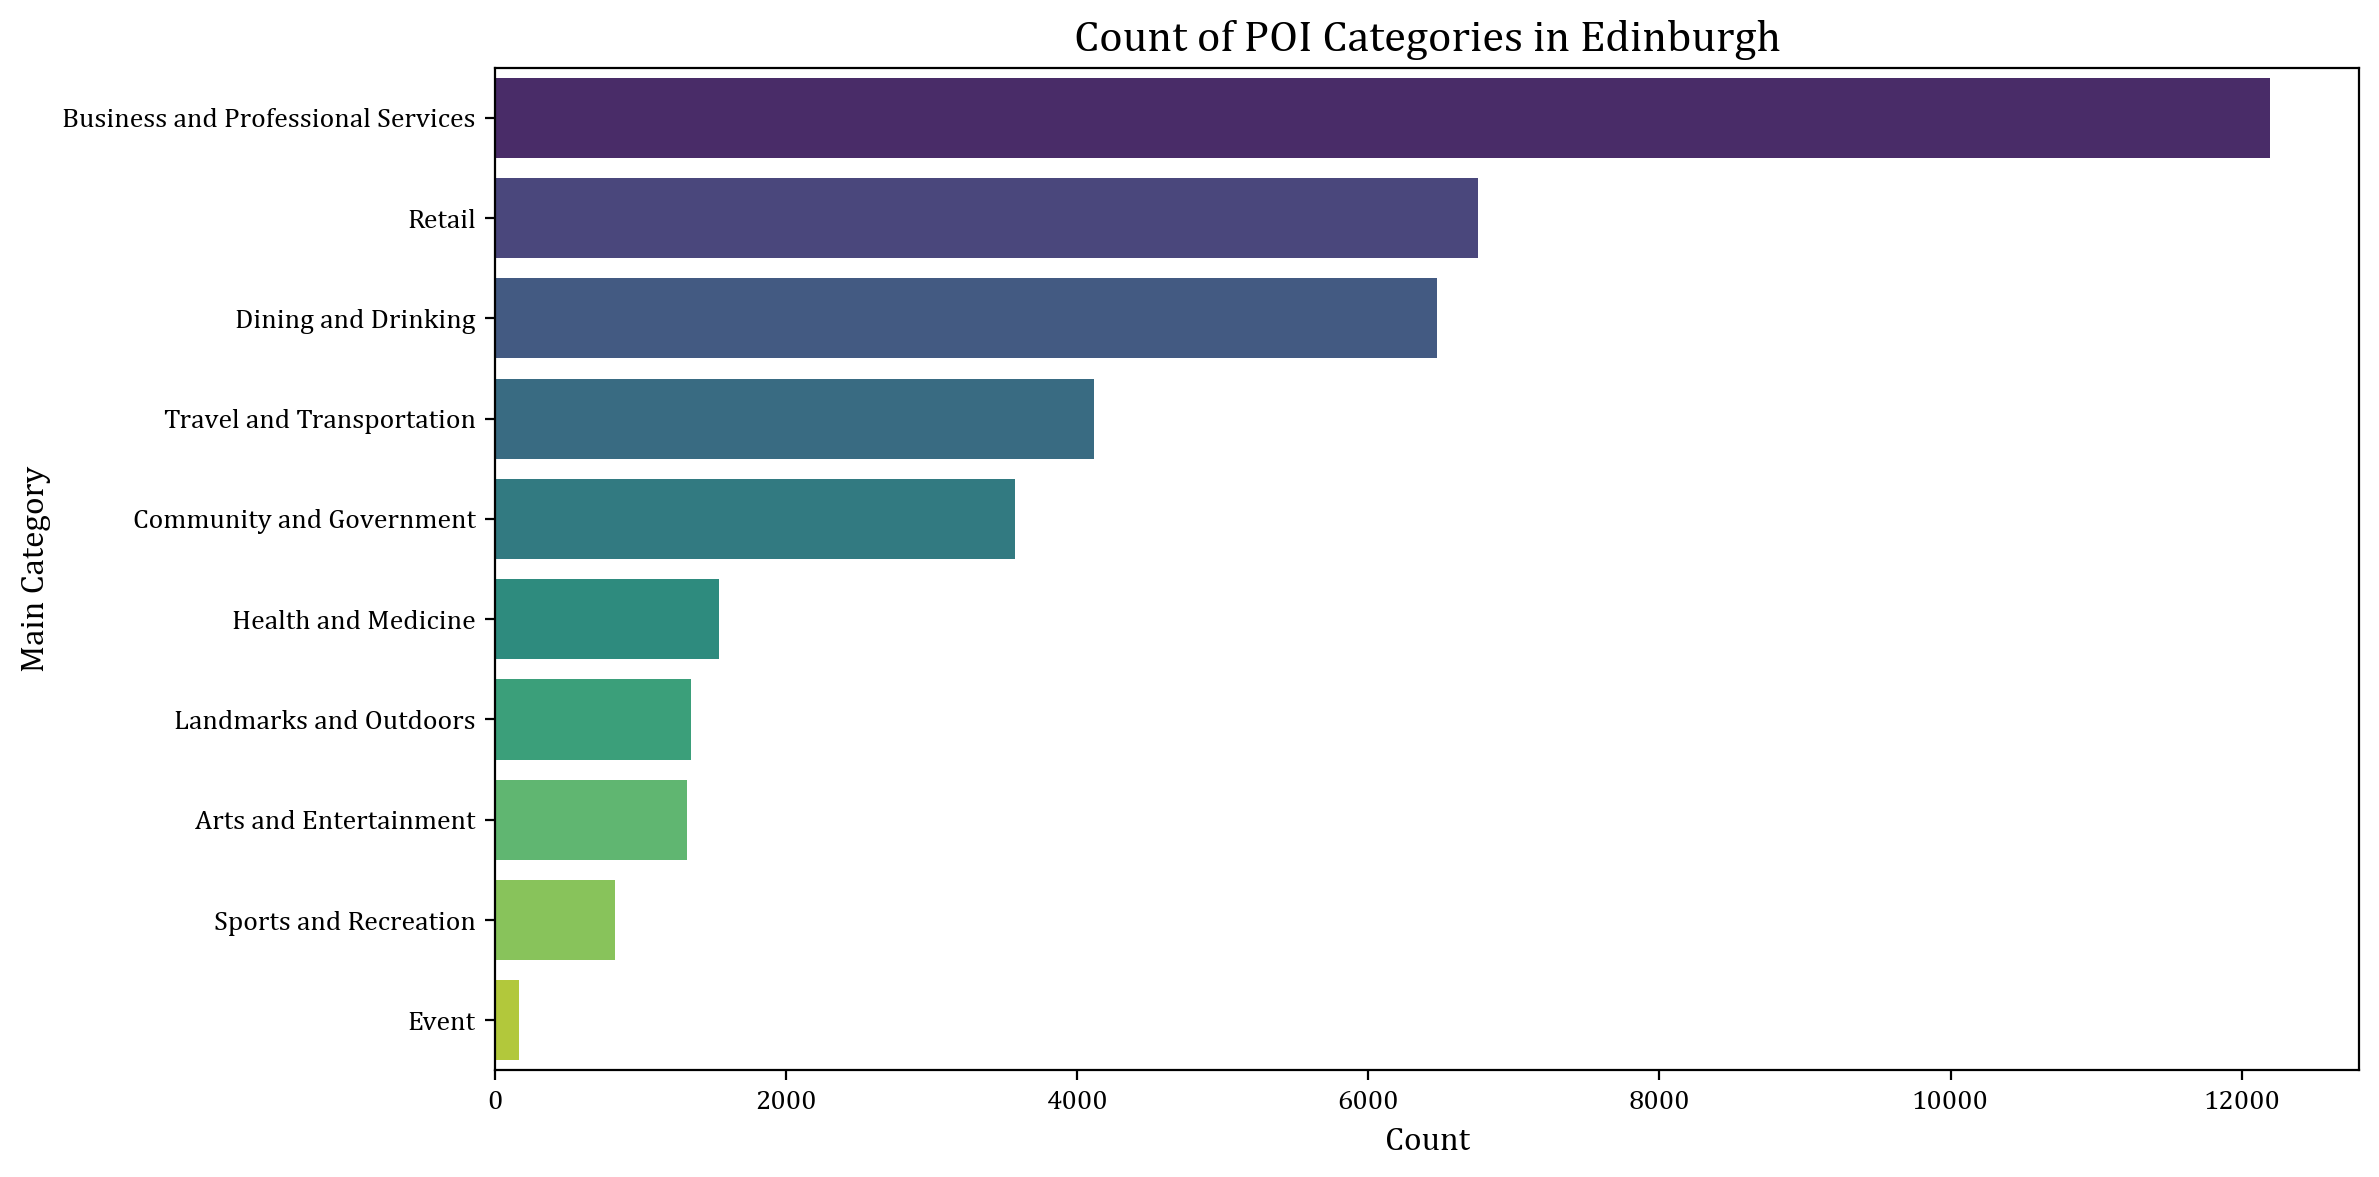

In [7]:
# Load custom font
cambria_path = "/Library/Fonts/Microsoft/Cambria.ttf" 
cambria_prop = fm.FontProperties(fname=cambria_path)

# Create the plot
#sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=fs_edinburgh_clipped,
    y="level1_category",
    order=fs_edinburgh_clipped["level1_category"].value_counts().index,
    palette="viridis"
)

# Set custom font on each text element
plt.title("Count of POI Categories in Edinburgh", fontproperties=cambria_prop, fontsize=16)
plt.xlabel("Count", fontproperties=cambria_prop, fontsize=12)
plt.ylabel("Main Category", fontproperties=cambria_prop, fontsize=12)

# Update tick labels to use the font
for label in ax.get_xticklabels():
    label.set_fontproperties(cambria_prop)
for label in ax.get_yticklabels():
    label.set_fontproperties(cambria_prop)

plt.tight_layout()
plt.show()

## 5. Aggregate POIs to Towns

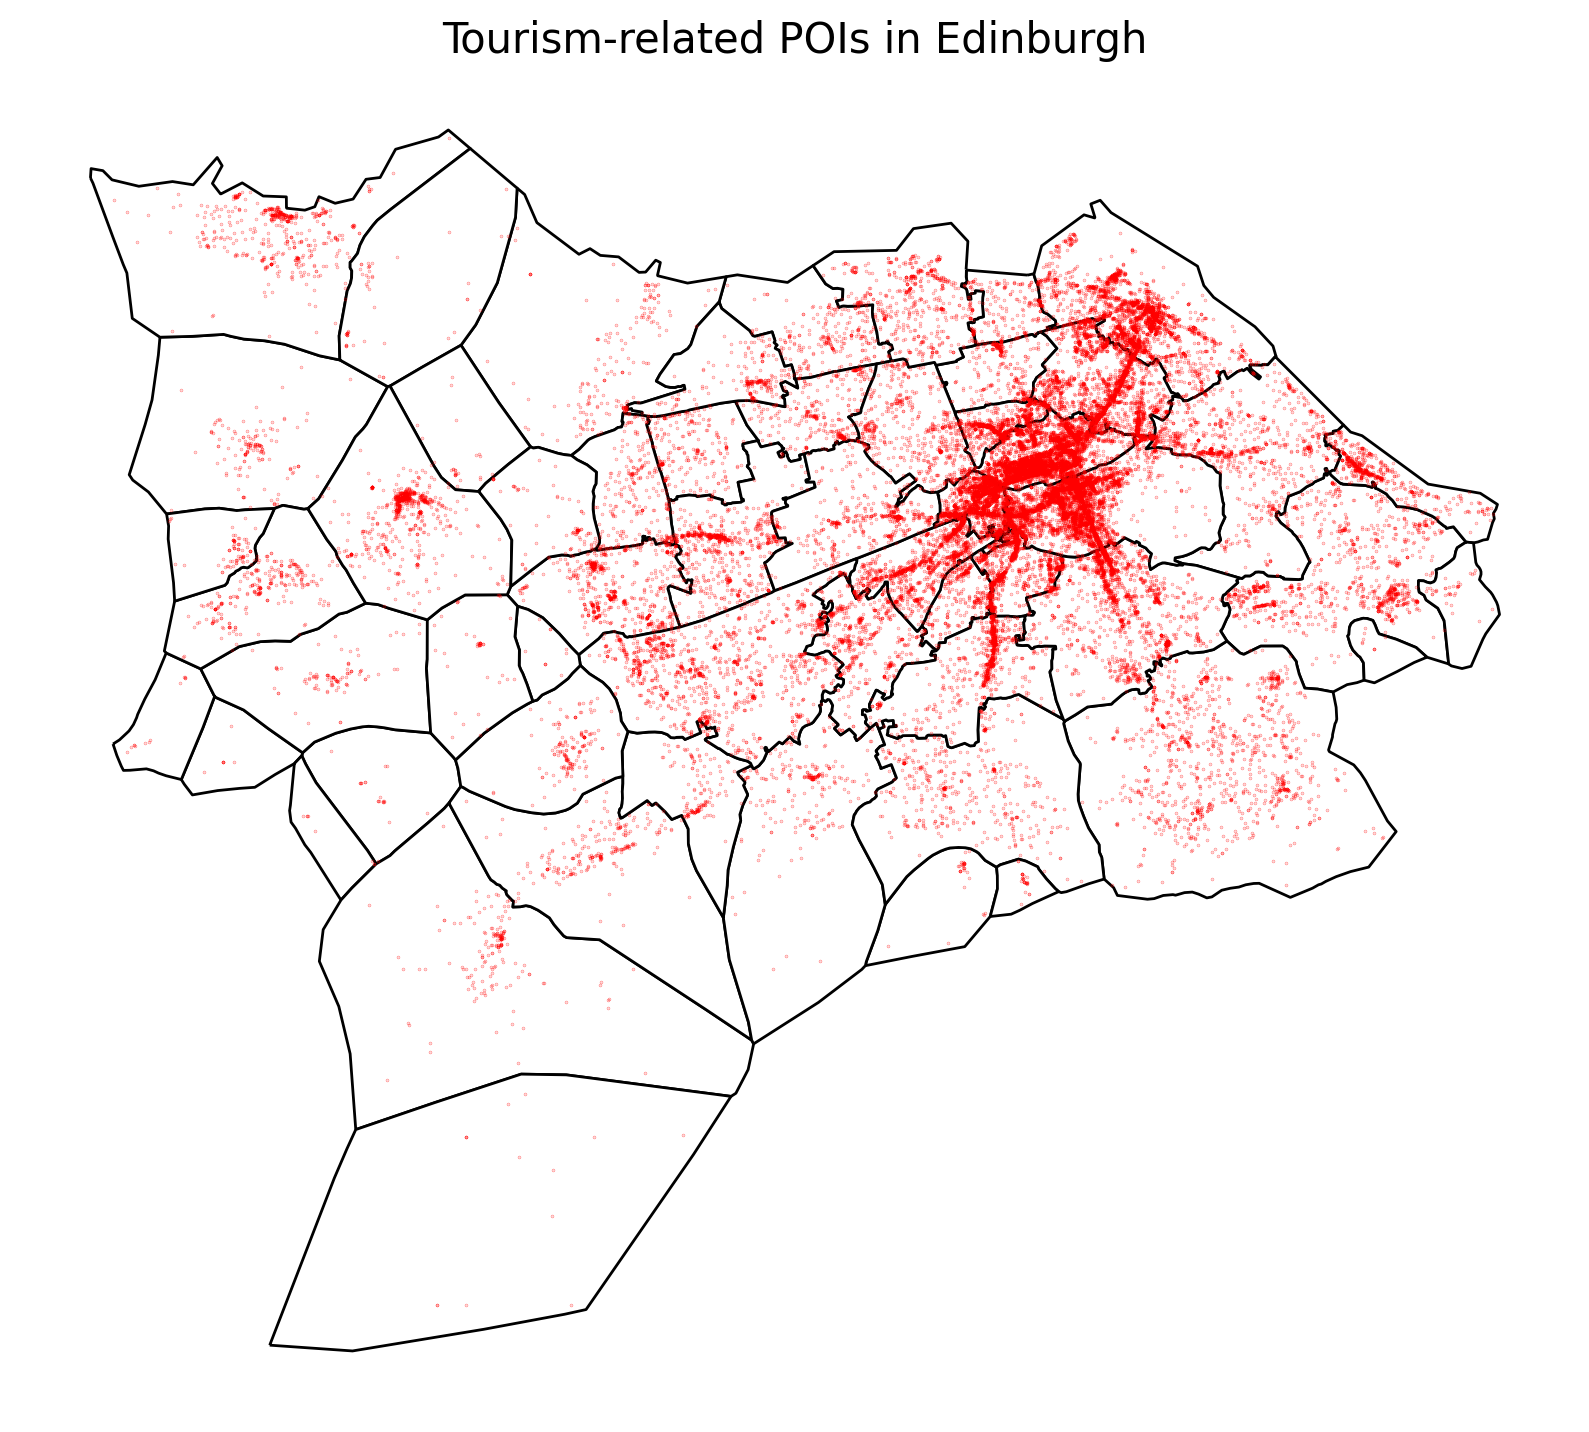

In [8]:
# Plot town boundaries
ax = edinburgh_seamless.plot(figsize = (10,10), color = "white", edgecolor="black")
# Plot poi points
fs_edinburgh_clipped.plot(ax = ax, color = "red", markersize = 0.05, alpha = 0.5)

ax.set_title("Tourism-related POIs in Edinburgh", fontsize = 15)
ax.set_axis_off()

In [8]:
# Drop sjoin artifacts if they exist
for df in [fs_edinburgh_clipped, edinburgh_seamless]:
    if 'index_right' in df.columns:
        df.drop(columns = 'index_right', inplace = True)

# Count POIs per area and category
edinburgh_fs_cat_count = (
    fs_edinburgh_clipped.groupby(['id', 'level1_category'])
    .size()
    .reset_index(name = 'count')
)

# Pivot to wide format
edinburgh_fs_cat_count_pivot = edinburgh_fs_cat_count.pivot_table(
    index = 'id',
    columns = 'level1_category',
    values = 'count',
    fill_value=0
).reset_index()

# Merge counts with geometry
fs_edinburgh_counts = edinburgh_seamless.merge(edinburgh_fs_cat_count_pivot, on = 'id', how = 'left')
fs_edinburgh_counts.fillna(0, inplace = True)

# Calculate total POIs per area
fs_edinburgh_counts_cols = edinburgh_fs_cat_count_pivot.columns.difference(['id'])
fs_edinburgh_counts['total_pois'] = fs_edinburgh_counts[fs_edinburgh_counts_cols].sum(axis = 1)

# Calculate proportions
for col in fs_edinburgh_counts_cols:
    fs_edinburgh_counts[f'{col}_count'] = fs_edinburgh_counts[col]
    fs_edinburgh_counts[f'{col}_proportion'] = fs_edinburgh_counts[col] / fs_edinburgh_counts['total_pois'].replace(0, pd.NA)

# Reproject to British National Grid for accurate area calculation
fs_edinburgh_counts = fs_edinburgh_counts.to_crs(epsg=27700)

# Calculate area and density
fs_edinburgh_counts['area_km2'] = fs_edinburgh_counts.geometry.area / 1e6

for col in fs_edinburgh_counts_cols:
    fs_edinburgh_counts[f'{col}_density'] = fs_edinburgh_counts[col] / fs_edinburgh_counts['area_km2'].replace(0, pd.NA)

# Drop raw category cols
fs_edinburgh_counts.drop(columns = fs_edinburgh_counts_cols, inplace = True)

# Get log values for all columns
# Identify all count, proprotion, and density columns
fs_log_targets = [col for col in fs_edinburgh_counts.columns if col.endswith(('_count', '_proportion', '_density'))]

# Log-transform
for col in fs_log_targets:
    log_col = f'{col}_log'
    fs_edinburgh_counts[log_col] = np.log1p(pd.to_numeric(fs_edinburgh_counts[col], errors='coerce').fillna(0))

/var/folders/1n/_7fnqrv504n3tlnbg2hqgkdh0000gn/T/ipykernel_26008/539460600.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fs_edinburgh_counts.fillna(0, inplace = True)


In [9]:
# Identify the first 10 * _count_log columns
fs_edinburgh_count_log_cols = [col for col in fs_edinburgh_counts if col.endswith('_count_log')][:10]
# Identify the first 10 * _density_log columns
fs_edinburgh_density_log_cols = [col for col in fs_edinburgh_counts.columns if col.endswith('_density_log')][:10]
# Identify the first 10 * _proportion_log columns
fs_edinburgh_proportion_log_cols = [col for col in fs_edinburgh_counts.columns if col.endswith('_proportion_log')][:10]

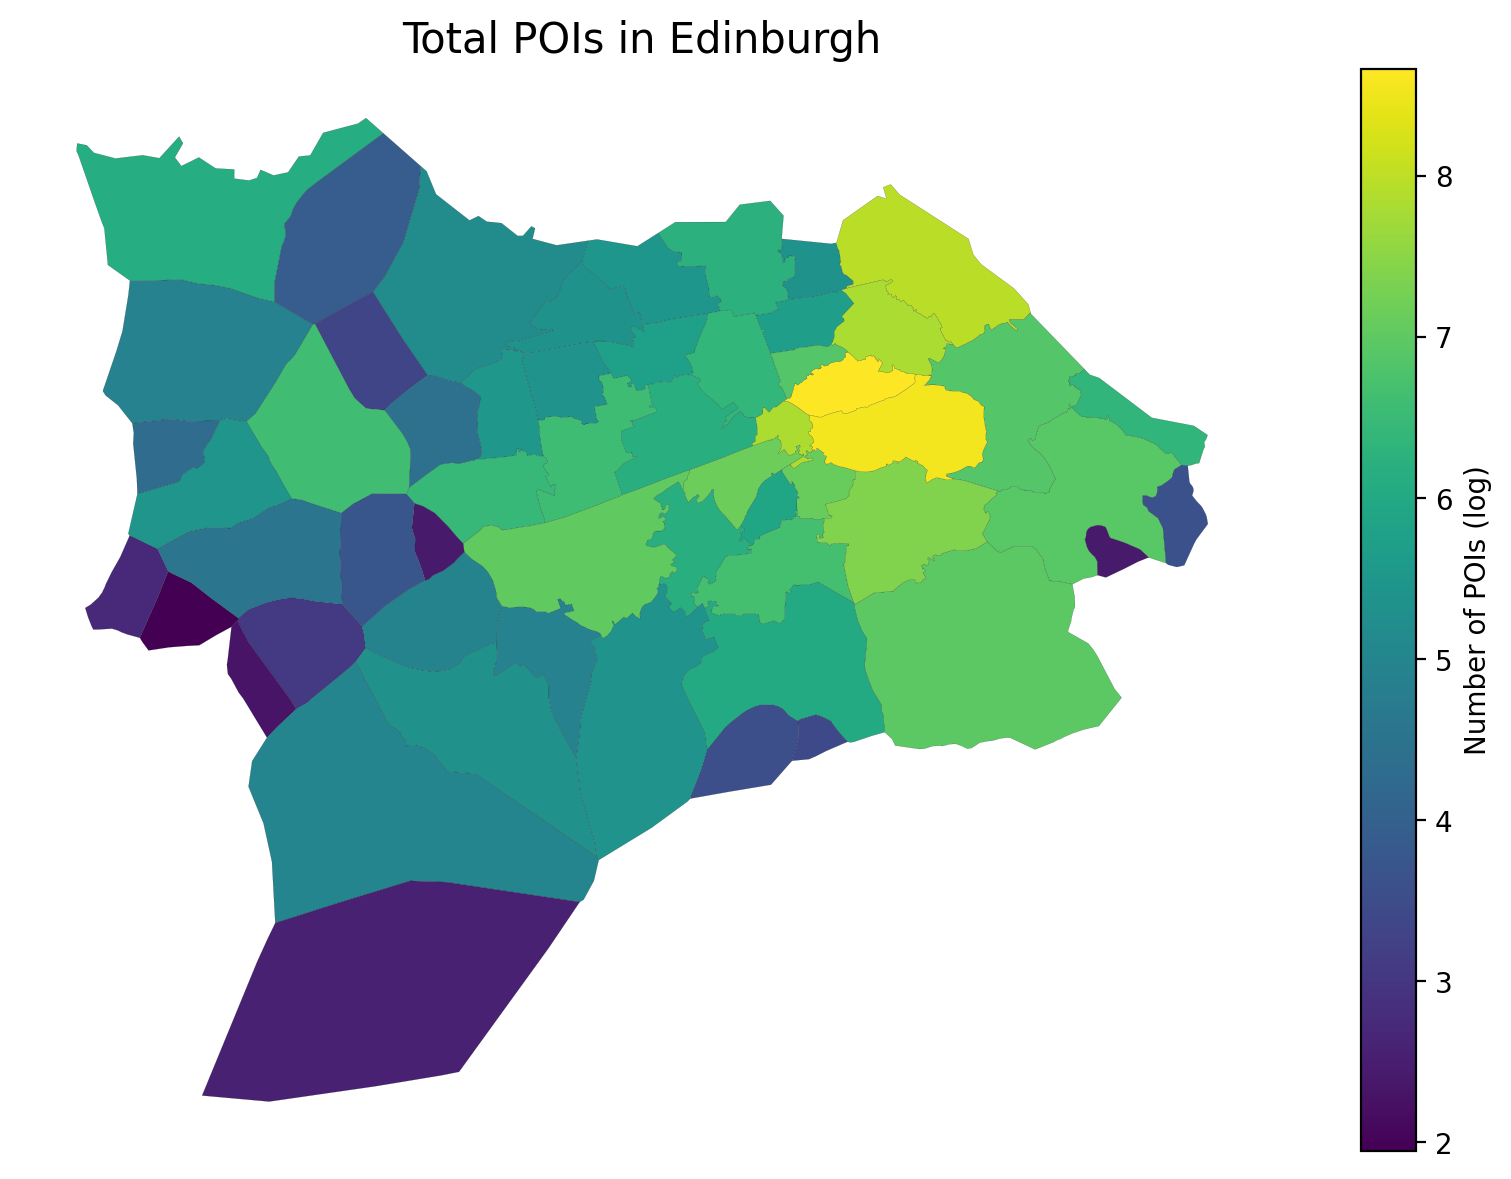

In [10]:
# log the total_pois column
fs_edinburgh_counts['total_pois_log'] = np.log1p(fs_edinburgh_counts['total_pois']+1)

# ---- Create graph for all POIs ----
fig, ax = plt.subplots(figsize=(10, 6))

fs_edinburgh_counts.plot(
    column='total_pois_log',
    cmap='viridis',
    legend=True,
    ax=ax,
    edgecolor='black',
    linewidth=0.05,
    legend_kwds={'label': "Number of POIs (log)", 'orientation': "vertical"}
)
ax.set_title("Total POIs in Edinburgh", fontsize=15)
ax.set_axis_off()
plt.tight_layout()
plt.show()

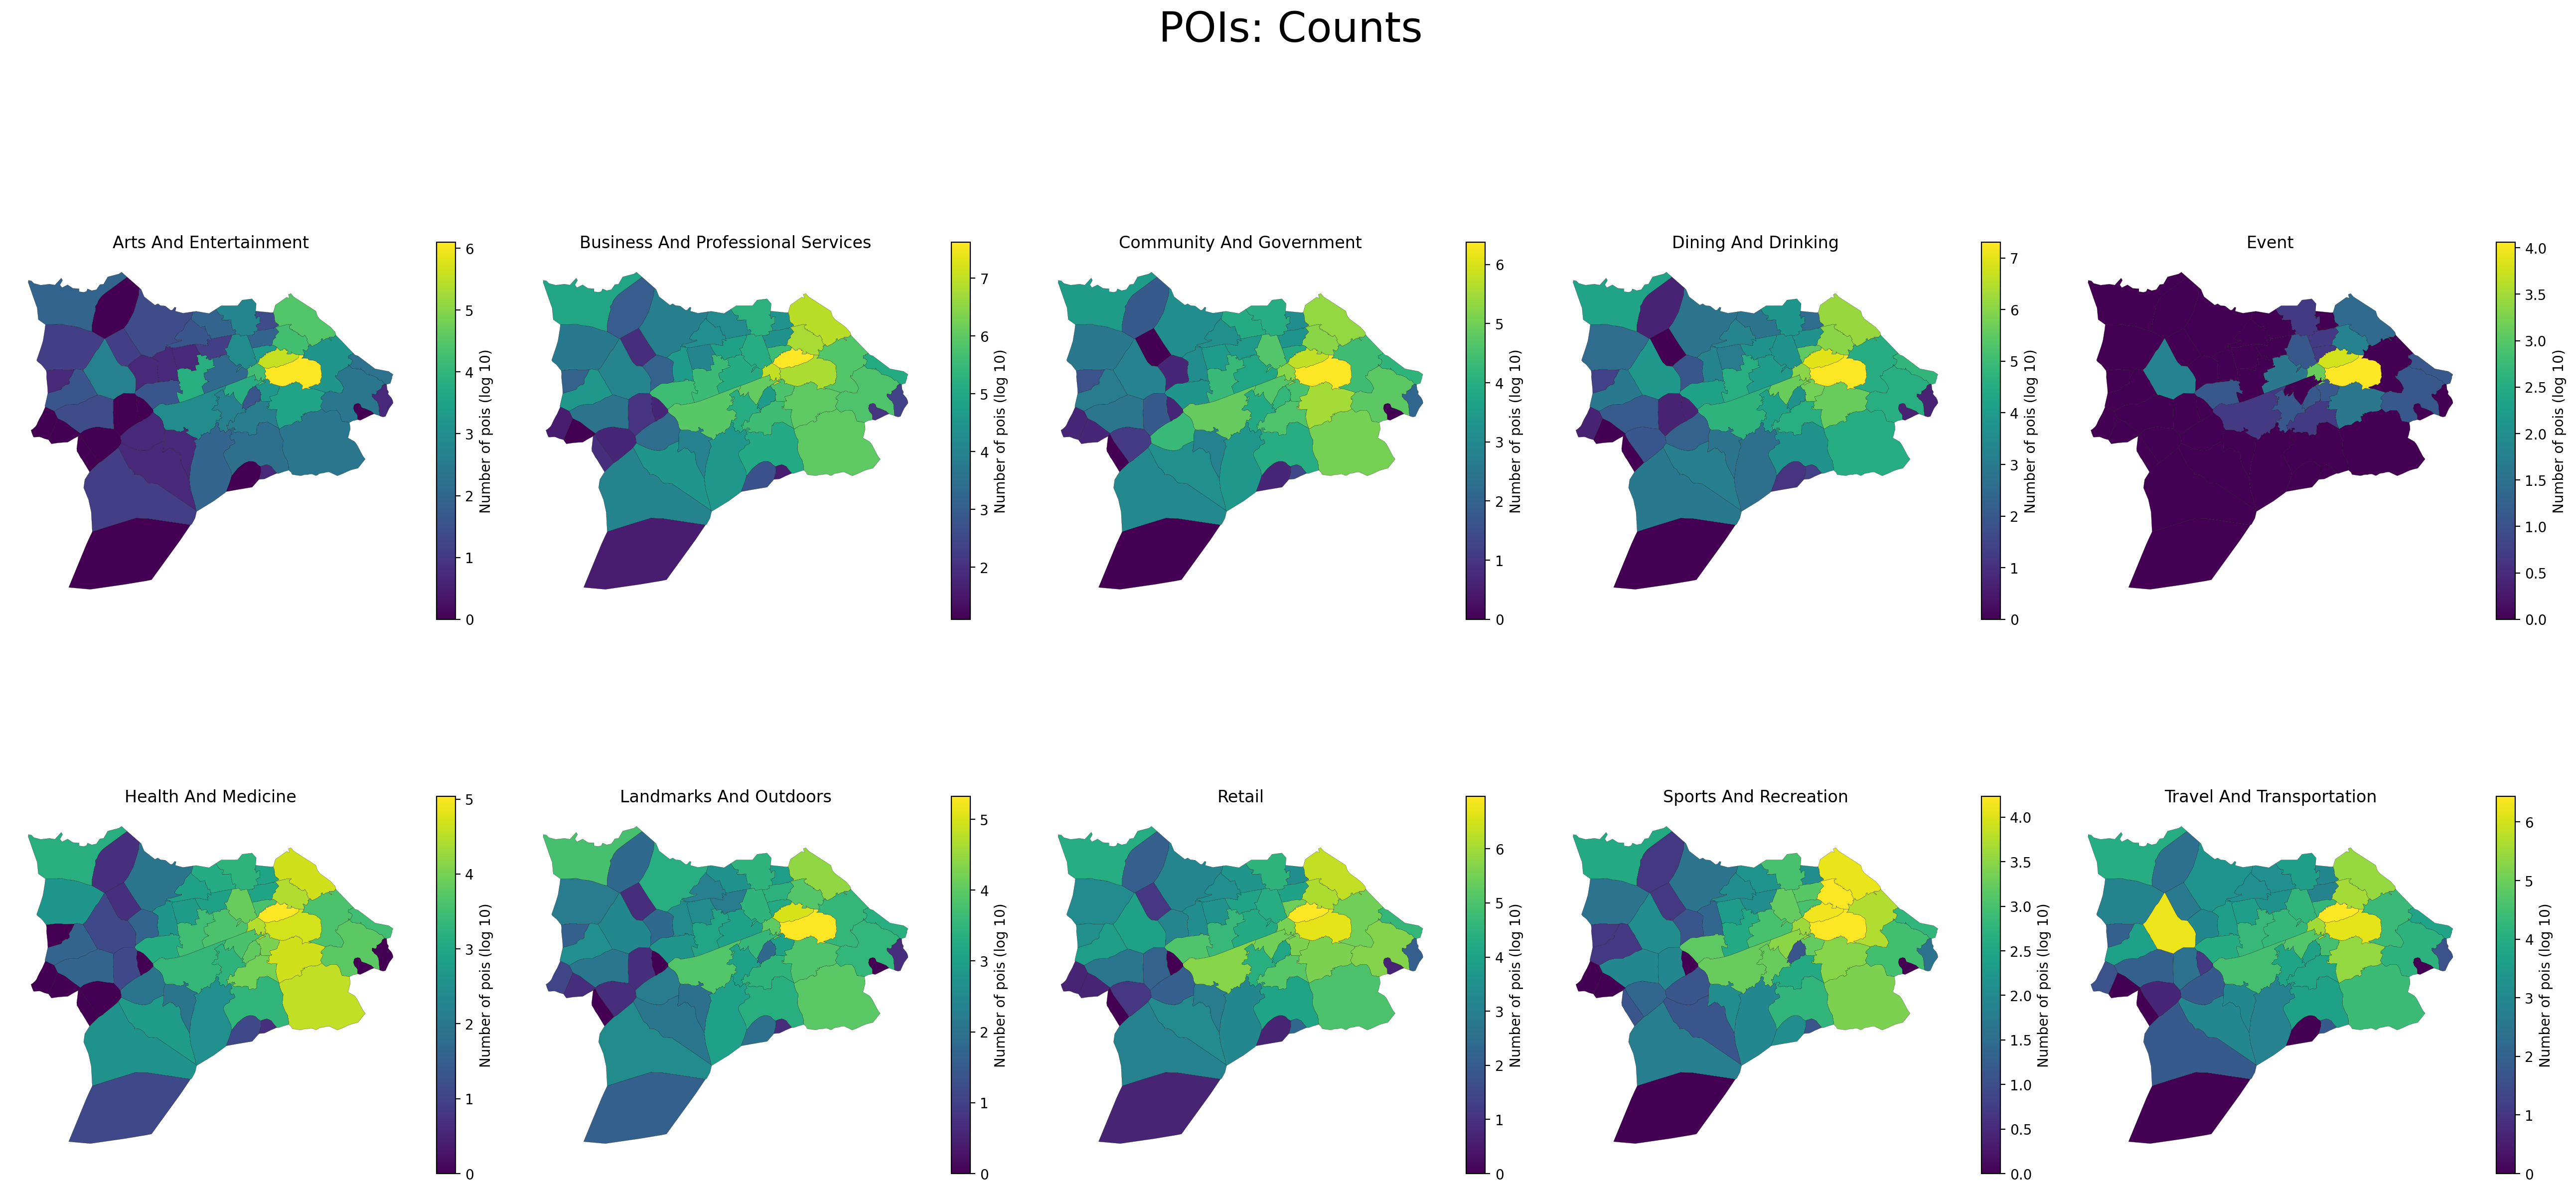

In [11]:
# ---- Create logged counts graph ----
# Create subplots (2 rows x 5 columns)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(26, 14))
axes = axes.flatten()

# Plot each category
for ax, col in zip(axes, fs_edinburgh_count_log_cols):
    fs_edinburgh_counts.plot(
        column=col,
        cmap='viridis',
        legend=True,
        edgecolor='black',
        linewidth=0.1,
        ax=ax,
        legend_kwds={"shrink": 0.5, "label": 'Number of pois (log 10)'},
    )
    ax.set_title(col.replace('_count_log', '').replace('_', ' ').title())
    ax.set_axis_off()

plt.suptitle("POIs: Counts", fontsize = 30)
plt.tight_layout()
plt.show()

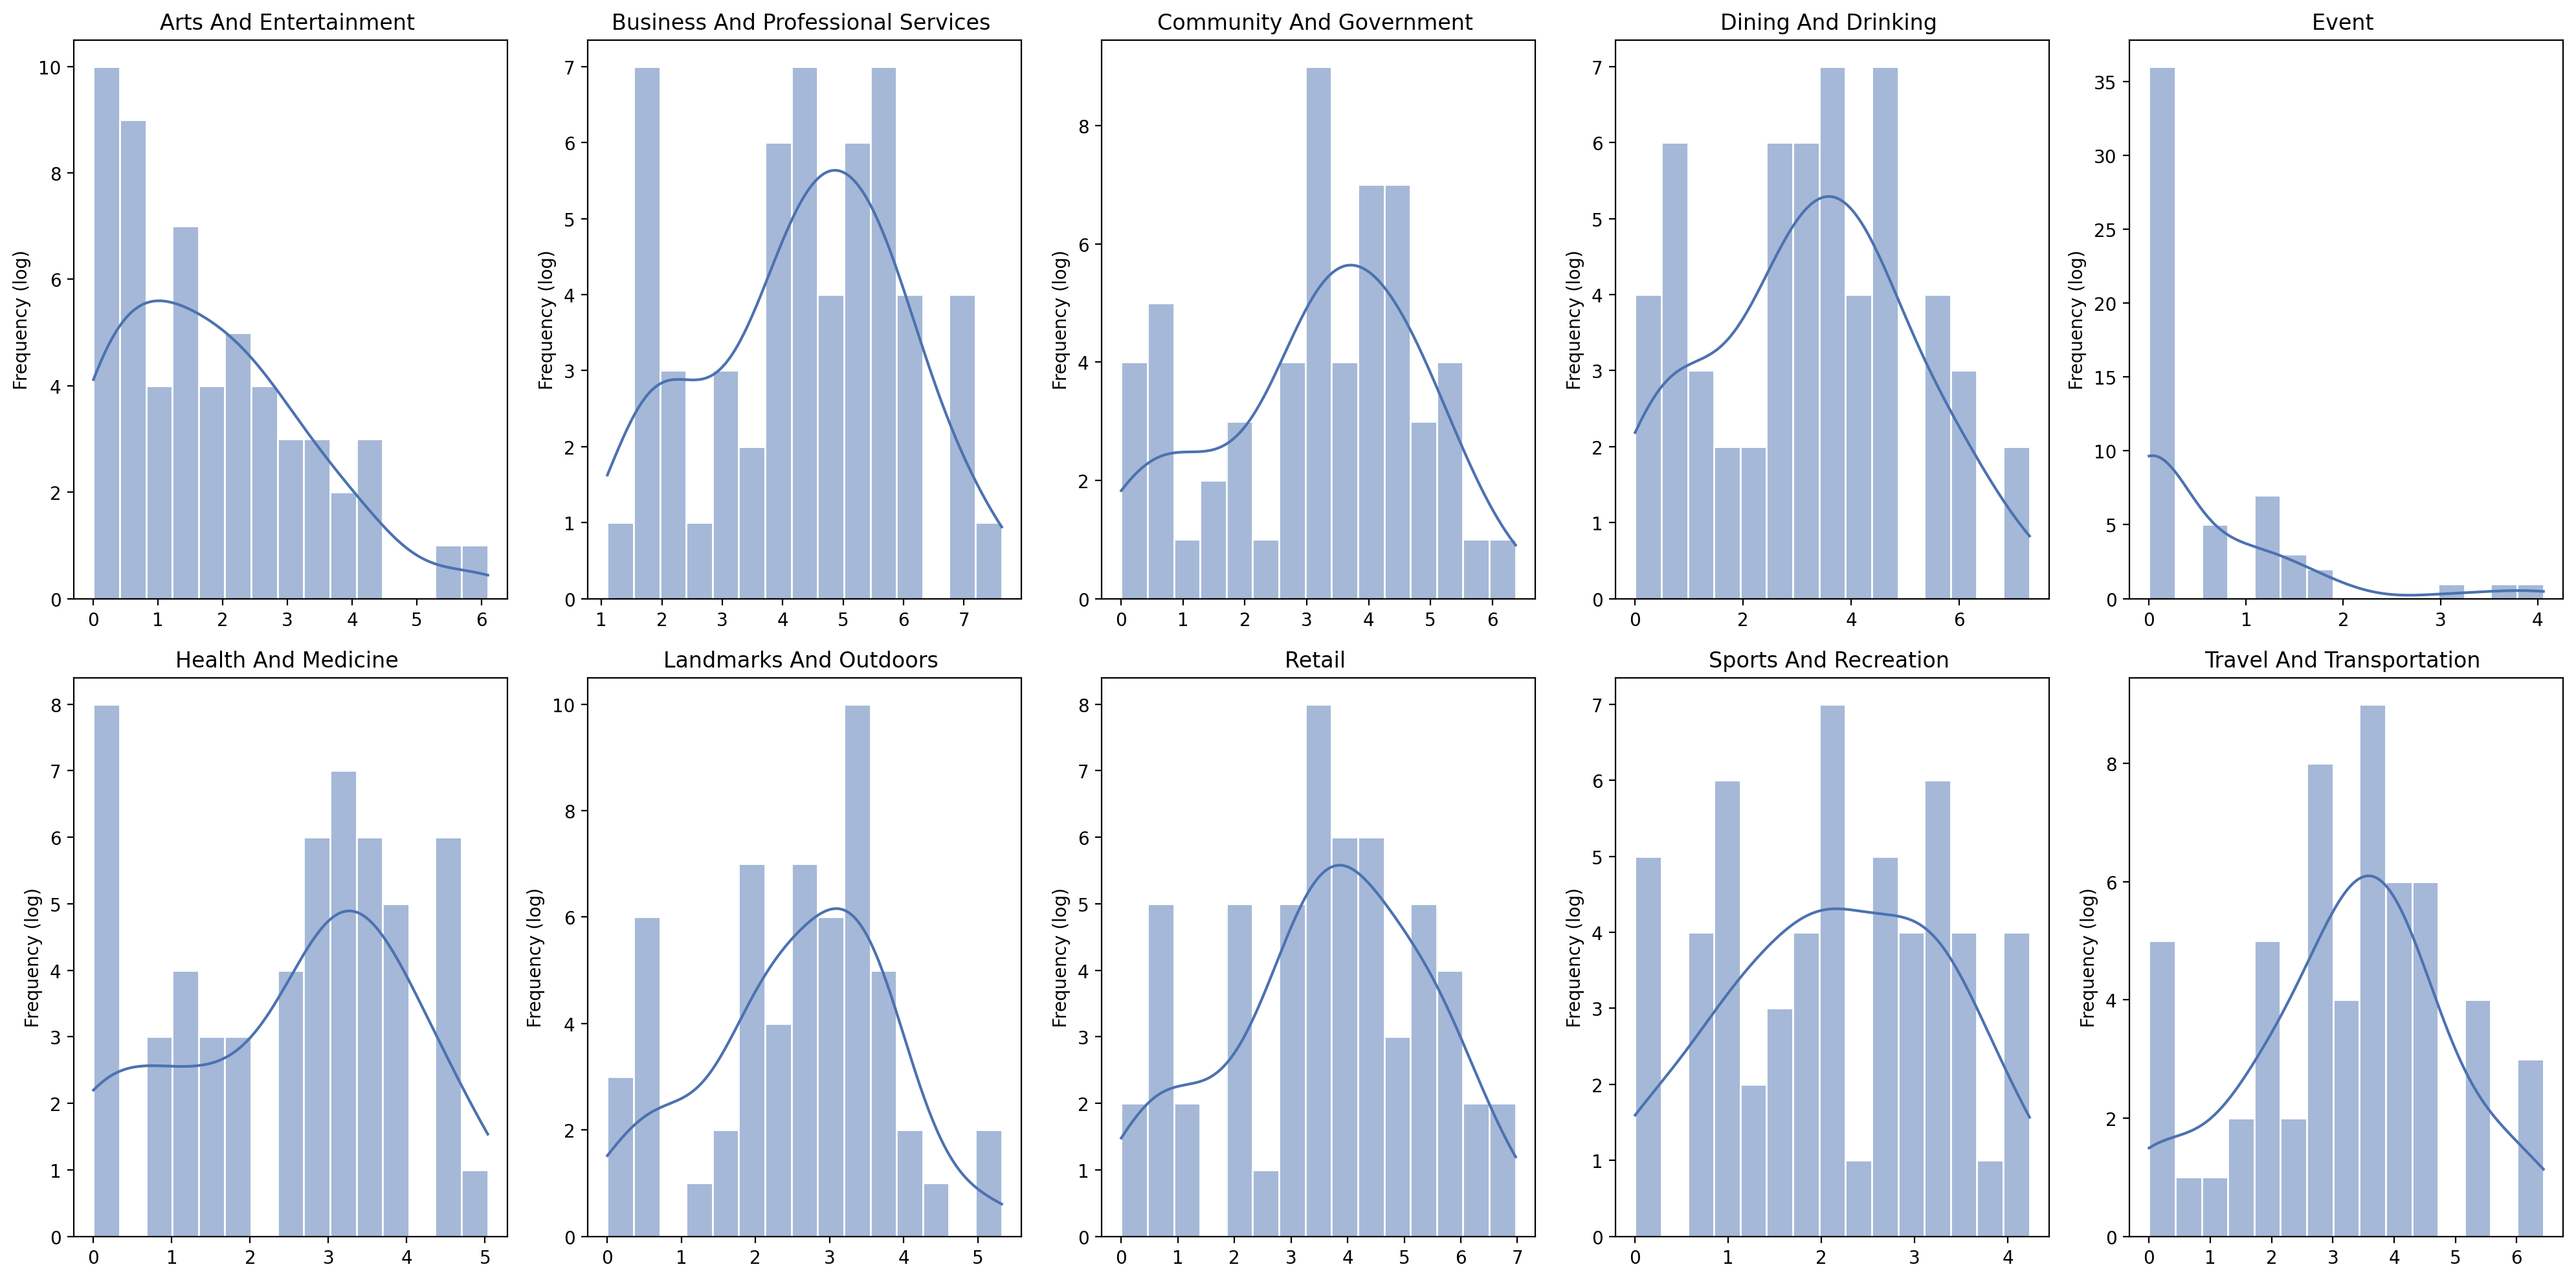

In [12]:
import seaborn as sns

## Histograms
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
axes = axes.flatten()

for i, col in enumerate(fs_edinburgh_count_log_cols):
    sns.histplot(
        data = fs_edinburgh_counts,
        x = col,
        ax = axes[i],
        kde = True,
        color = '#4c72b0',
        edgecolor = 'white',
        bins = 15
    )
    axes[i].set_title(col.replace("_count_log", " ").replace('_', ' ').title())
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequency (log)")
    axes[i].grid(False)

plt.tight_layout()
plt.show()

## 6. Refining Tourism-related POI Categories

In [13]:
tourism_categories = [
    "Arts and Entertainment", 
    "Dining and Drinking", 
    "Landmarks and Outdoors",
    "Retail",
    "Travel and Transportation",
    "id"
]

# Keep only tourism categories and others
edinburgh_tourism_pois = fs_edinburgh_clipped[fs_edinburgh_clipped["level1_category"].isin(tourism_categories)]

In [14]:
# Only keep relevant columns
edinburgh_tourism_pois = edinburgh_tourism_pois[[
    "fsq_place_id", "name", "post_town", 
    "latitude", "longitude", "address",
    "level1_category", "level2_category", "level3_category",
    "level4_category", "level5_category", "level6_category",
    "level7_category", "level8_category", "level9_category",
    "level10_category", "level11_category", "level12_category",
    "level13_category", "level14_category", "level15_category",
    "id",
    "geometry"
]]

### Create Unified Search Column

In [15]:
# Select all the category level columns that exist
level_cols = [f'level{i}_category' for i in range(1, 16)]
existing_level_cols = [col for col in level_cols if col in edinburgh_tourism_pois.columns]

# Also include the name and fsq_category_labels
search_cols = ['name'] + existing_level_cols

# Fill amy missing values (NaN) with empty strings
edinburgh_tourism_pois[search_cols] = edinburgh_tourism_pois[search_cols].fillna('')

# Join them all into a single, lowercase string
edinburgh_tourism_pois['search_corpus'] = edinburgh_tourism_pois[search_cols].apply(lambda row: ' '.join(row).lower(), axis=1)

edinburgh_tourism_pois['search_corpus'].head().tolist()

['lerwick travel and transportation pier             ',
 'bredero shaw retail construction supplies store             ',
 'hertfordshire air conditioning travel and transportation travel and transportation tourist information and service            ',
 'marco polo travel and transportation boat or ferry             ',
 'hms edinburgh travel and transportation boat or ferry             ']

### Dining and Drinking

In [16]:
# Filter the dataframe to only include 'Dining & Drinking' POIs
dining_df = edinburgh_tourism_pois[edinburgh_tourism_pois['level1_category'] == 'Dining and Drinking'].copy()

# Get all the unique sub-categories from Level 2 and Level 3 for dining
unique_level2_dining = dining_df['level2_category'].unique().tolist()
unique_level3_dining = dining_df['level3_category'].unique().tolist()

# Print them out in a clean format
print("--- Unique Level 2 Dining Categories ---")
print(unique_level2_dining)
print("\n" + "="*40 + "\n") # Separator
print("--- Unique Level 3 Dining Categories ---")
print(unique_level3_dining)

--- Unique Level 2 Dining Categories ---
['Bar', 'Restaurant', 'Bakery', 'Juice Bar', 'Dessert Shop', 'Cafe', 'Snack Place', 'Donut Shop', 'Distillery', 'Brewery', 'Breakfast Spot', '', 'Food Court', 'Bagel Shop', 'Food Truck', 'Creperie', 'Cafeteria', 'Vineyard', 'Smoothie Shop', 'Retail', 'Food Stand', 'Winery', 'Cidery']


--- Unique Level 3 Dining Categories ---
['Pub', '', 'Burger Joint', 'Pizzeria', 'Sandwich Spot', 'Hotel Bar', 'Falafel Restaurant', 'Ice Cream Parlor', 'Dining and Drinking', 'Mexican Restaurant', 'Asian Restaurant', 'Coffee', 'Indian Restaurant', 'American Restaurant', 'Italian Restaurant', 'Cocktail Bar', 'Mediterranean Restaurant', 'Greek Restaurant', 'Deli', 'Portuguese Restaurant', 'Retail', 'Spanish Restaurant', 'Lounge', 'Scottish Restaurant', 'French Restaurant', 'Seafood Restaurant', 'Turkish Restaurant', 'Diner', 'Wine Bar', 'Beer Bar', 'Fried Chicken Joint', 'Beer Garden', 'Fast Food Restaurant', 'Pastry Shop', 'Steakhouse', 'Gastropub', 'Sports Bar', 

In [17]:
def classify_dining(row):
    search_string = row['search_corpus']

    # --- Fine Dining / High-End ---
    if re.search(r'\bmichelin\b|fine dining|molecular gastronomy|cocktail bar|speakeasy|rooftop bar|whisky bar|wine bar', search_string):
        return 'high_end_dining'

    # --- Bars & Nightlife ---
    if re.search(r'pub|gastropub|beer garden|beer bar|sports bar|hotel bar|nightclub|karaoke|piano bar|gay bar|bar\b|lounge', search_string):
        return 'bars_nightlife'

    # --- Cafes, Bakeries, Dessert Shops ---
    if re.search(r'cafe|coffee|creperie|bakery|pastry|cupcake|donut|dessert|ice cream|gelato|frozen yogurt|waffle|juice bar|smoothie', search_string):
        return 'cafes_bakeries'

    # --- Quick Service / Fast Food ---
    if re.search(r'fast food|fried chicken|kebab|burger|sandwich|pie shop|hot dog|wings|falafel|pizzeria|food truck|food stand|snack place', search_string):
        return 'fast_food'

    # --- Full-Service Restaurants (cultural/regional) ---
    if re.search(r'italian|french|spanish|greek|portuguese|english|european|polish|german|scandinavian|scottish|asian|indian|pakistani|bangladeshi|sri lankan|afghan|halal|dumpling|seafood|middle eastern|turkish|mediterranean|moroccan|american|mexican|latin american|caribbean|southern food|african|vegan|vegetarian', search_string):
        return 'full_service_restaurant'

    # --- Brewery / Distillery ---
    if re.search(r'brewery|distillery|winery|vineyard|cidery', search_string):
        return 'food_drink_production'

    # --- Other ---
    if re.search(r'food court|cafeteria', search_string):
        return 'dining_other'

    return 'dining_other'

In [18]:
# Create a mask for the 'Dining & Drinking' category
dining_mask = edinburgh_tourism_pois['level1_category'] == 'Dining and Drinking'

# Apply the function to the dining rows
edinburgh_tourism_pois.loc[dining_mask, 'refined_category'] = edinburgh_tourism_pois[dining_mask].apply(classify_dining, axis=1)

In [19]:
# See the breakdown of your new dining categories
print(edinburgh_tourism_pois[dining_mask]['refined_category'].value_counts())

refined_category
cafes_bakeries             1870
full_service_restaurant    1490
bars_nightlife             1305
fast_food                   807
dining_other                715
high_end_dining             225
food_drink_production        60
Name: count, dtype: int64


### Retail

In [20]:
# Filter the dataframe to only include 'Retail' POIs
retail_df = edinburgh_tourism_pois[edinburgh_tourism_pois['level1_category'] == 'Retail'].copy()

# Get all the unique sub-categories from Level 2 and Level 3 for retail
unique_level2_retail = retail_df['level2_category'].unique().tolist()
unique_level3_retail = retail_df['level3_category'].unique().tolist()

# Print them out in a clean format
print("--- Unique Level 2 Retail Categories ---")
print(unique_level2_retail)
print("\n" + "="*40 + "\n") # Separator
print("--- Unique Level 3 Retail Categories ---")
print(unique_level3_retail)

--- Unique Level 2 Retail Categories ---
['Construction Supplies Store', 'Gift Store', 'Fashion Retail', 'Department Store', 'Cosmetics Store', 'Arts and Crafts Store', 'Hobby Store', 'Toy Store', 'Food and Beverage Retail', 'Computers and Electronics Retail', 'Furniture and Home Store', 'Pharmacy', 'Shopping Mall', 'Music Store', 'Miscellaneous Store', 'Eyecare Store', 'Office Supply Store', 'Discount Store', 'Framing Store', 'Bookstore', 'Boutique', '', 'Market', 'Warehouse or Wholesale Store', 'Medical Supply Store', 'Print Store', 'Automotive Retail', 'Packaging Supply Store', 'Betting Shop', 'Newsagent', 'Pet Supplies Store', 'Sporting Goods Retail', 'Convenience Store', 'Garden Center', 'Auction House', 'Stationery Store', 'Smoke Shop', 'Antique Store', 'Hardware Store', 'Flower Store', 'Pawn Shop', 'Video Store', 'Flea Market', 'Outlet Store', 'Textiles Store', 'Vintage and Thrift Store', 'Costume Store', 'Record Store', 'Baby Store', 'Tobacco Store', 'Drugstore', 'Newsstand', '

In [21]:
luxury_fashion_brands = [
    'gucci', 'prada', 'louis vuitton', 'chanel', 'hermès', 'hermes', 'burberry',
    'dior', 'saint laurent', 'balenciaga', 'fendi', 'versace', 'valentino',
    'alexander mcqueen', 'celine', 'givenchy', 'loewe'
]

luxury_jewelry_brands = [
    'tiffany & co', 'cartier', 'bulgari', 'bvlgari', 'rolex', 'patek philippe',
    'audemars piguet', 'omega', 'tag heuer', 'breitling', 'vacheron constantin'
]

def classify_retail(row):
    search_string = row['search_corpus']

    # --- Luxury ---
    if re.search(r'\bluxury\b', search_string) or re.search(r'\bboutique\b', search_string) or \
       any(re.search(rf'\b{re.escape(brand)}\b', search_string) for brand in luxury_fashion_brands + luxury_jewelry_brands):
        return 'retail_luxury'

    # --- Fashion / Apparel ---
    if re.search(r'\b(clothing|fashion|shoe|accessor(y|ies)|thrift|vintage|mens|womens)\b', search_string):
        return 'retail_fashion_apparel'

    # --- Food & Beverage Retail ---
    if re.search(r'\b(supermarket|grocery|convenience|liquor|wine|beer|butcher|cheese|candy|chocolate|gourmet|market)\b', search_string):
        return 'retail_food_beverage'

    # --- Home & Electronics ---
    if re.search(r'\b(electronics|mobile|computer|furniture|home|kitchen|camera)\b', search_string):
        return 'retail_home_electronics'

    # --- Books & Hobbies ---
    if re.search(r'\b(bookstore|comic|music|record|hobby|craft|art|newsagent|newsstand)\b', search_string):
        return 'retail_books_hobbies'

    # --- Health & Beauty ---
    if re.search(r'\b(pharmacy|drugstore|cosmetics|perfume|vape)\b', search_string):
        return 'retail_health_beauty'

    # --- Gifts & Misc ---
    if re.search(r'\b(gift|souvenir|toy|flower|garden|discount|pawn|outlet)\b', search_string):
        return 'retail_gifts_misc'

    # --- Markets & Plazas ---
    if re.search(r'\b(department store|shopping mall|plaza|flea market|farmers market|duty[-\s]?free)\b', search_string):
        return 'retail_markets_plazas'

    return 'retail_other'

In [22]:
# Create a mask for the 'Retail' category
retail_mask = edinburgh_tourism_pois['level1_category'] == 'Retail'

# Apply the classification function to the retail rows
edinburgh_tourism_pois.loc[retail_mask, 'refined_category'] = edinburgh_tourism_pois.loc[retail_mask].apply(classify_retail, axis=1)

In [23]:
print(edinburgh_tourism_pois[retail_mask]['refined_category'].value_counts())

refined_category
retail_other               2578
retail_fashion_apparel     1184
retail_food_beverage       1094
retail_home_electronics     627
retail_gifts_misc           511
retail_health_beauty        304
retail_books_hobbies        304
retail_luxury                89
retail_markets_plazas        60
Name: count, dtype: int64


### Arts and Entertainment

In [24]:
# Filter the dataframe to only include 'Arts and Entertainment' POIs
arts_df = edinburgh_tourism_pois[edinburgh_tourism_pois['level1_category'] == 'Arts and Entertainment'].copy()

# Get all the unique sub-categories from Level 2 and Level 3 for arts
unique_level2_arts = arts_df['level2_category'].unique().tolist()
unique_level3_arts = arts_df['level3_category'].unique().tolist()

# Print them out in a clean format
print("--- Unique Level 2 Arts and Entertainment Categories ---")
print(unique_level2_arts)
print("\n" + "="*40 + "\n") # Separator
print("--- Unique Level 3 Arts and Entertainment Categories ---")
print(unique_level3_arts)

--- Unique Level 2 Arts and Entertainment Categories ---
['Arcade', 'Roller Rink', 'Movie Theater', 'Art Gallery', 'Performing Arts Venue', '', 'Museum', 'Exhibit', 'Dining and Drinking', 'Business and Professional Services', 'Public Art', 'Strip Club', 'Fair', 'Night Club', 'Escape Room', 'Casino', 'Internet Cafe', 'Amusement Park', 'Ticket Seller', 'Stadium', 'Bingo Center', 'Water Park', 'Landmarks and Outdoors', 'Bowling Alley', 'Pool Hall', 'Comedy Club', 'Aquarium', 'Zoo', 'Circus', 'Planetarium', 'Mini Golf Course', 'Go Kart Track', 'Gaming Cafe', 'Retail', 'Arts and Entertainment', 'Community and Government', 'Event', 'Psychic and Astrologer', 'Laser Tag Center', 'Disc Golf']


--- Unique Level 3 Arts and Entertainment Categories ---
['', 'Theater', 'Cafe', 'Entertainment Service', 'Business and Professional Services', 'Music Venue', 'Audiovisual Service', 'Dining and Drinking', 'Soccer Stadium', 'Indie Movie Theater', 'Outdoor Sculpture', 'Park', 'Track Stadium', 'Retail', 'Ev

In [25]:
def classify_arts(row):
    search_string = row['search_corpus'].lower()

    # --- Cultural Institutions ---
    if re.search(r'\b(museum|gallery|planetarium|exhibit|opera house|concert hall|performing arts venue|amphitheater)\b', search_string):
        return 'cultural_institution'

    # --- Music / Cinema Venues ---
    if re.search(r'\b(music venue|movie theater|cinema)\b', search_string):
        return 'music_cinema_venue'

    # --- Major Venues & Attractions ---
    if re.search(r'\b(stadium|convention center|zoo|amusement park|water park|fair|carnival|aquarium)\b', search_string):
        return 'major_attraction'

    # --- Entertainment & Nightlife ---
    if re.search(r'\b(comedy club|night club|strip club|salsa club|dance hall|casino)\b', search_string):
        return 'entertainment_nightlife'

    # --- Leisure / Activity Centres ---
    if re.search(r'\b(arcade|gaming cafe|vr cafe|laser tag|bowling alley|pool hall|mini golf|go kart|escape room|roller rink|bingo)\b', search_string):
        return 'leisure_activity_centre'

    # --- Public Art ---
    if re.search(r'\b(public art|sculpture|street art)\b', search_string):
        return 'public_art'

    # --- Event Space ---
    if re.search(r'\b(event space|party center)\b', search_string):
        return 'event_space'

    return 'arts_other'

In [26]:
# Create a mask for the 'Arts and Entertainment' category
arts_mask = edinburgh_tourism_pois['level1_category'] == 'Arts and Entertainment'

# Apply the classification function to the arts rows
edinburgh_tourism_pois.loc[arts_mask, 'refined_category'] = edinburgh_tourism_pois.loc[arts_mask].apply(classify_arts, axis=1)

In [27]:
print(edinburgh_tourism_pois[arts_mask]['refined_category'].value_counts())

refined_category
cultural_institution       684
arts_other                 271
entertainment_nightlife    172
leisure_activity_centre     69
major_attraction            60
public_art                  32
music_cinema_venue          29
event_space                  2
Name: count, dtype: int64


### Travel and Transportation

In [28]:
# Filter the dataframe to only include 'Travel and Transportation' POIs
travel_df = edinburgh_tourism_pois[edinburgh_tourism_pois['level1_category'] == 'Travel and Transportation'].copy()

# Get all the unique sub-categories from Level 2 and Level 3 for arts
unique_level2_travel = travel_df['level2_category'].unique().tolist()
unique_level3_travel = travel_df['level3_category'].unique().tolist()

# Print them out in a clean format
print("--- Unique Level 2 Travel and Transportation Categories ---")
print(unique_level2_travel)
print("\n" + "="*40 + "\n") # Separator
print("--- Unique Level 3 Travel and Transportation Categories ---")
print(unique_level3_travel)

--- Unique Level 2 Travel and Transportation Categories ---
['Pier', 'Travel and Transportation', 'Boat or Ferry', 'Transport Hub', 'Lodging', 'Train', 'Parking', 'Travel Agency', 'Tourist Information and Service', '', 'Cruise', 'Port', 'Road', 'Transportation Service', 'Fuel Station', 'Platform', 'Moving Target', 'Electric Vehicle Charging Station', 'Border Crossing', 'Rest Area', 'Baggage Locker', 'RV Park', 'Bike Rental', 'Travel Lounge', 'Business and Professional Services', 'Arts and Entertainment', 'Boat Rental']


--- Unique Level 3 Travel and Transportation Categories ---
['', 'Tourist Information and Service', 'Bus Stop', 'Hotel', 'Tram Station', 'Business and Professional Services', 'Bed and Breakfast', 'Arts and Entertainment', 'Dining and Drinking', 'Rental Car Location', 'Vacation Rental', 'Tour Provider', 'Taxi', 'Hostel', 'Taxi Stand', 'Bus Station', 'Public Transportation', 'Boarding House', 'Charter Bus', 'Cabin', 'Limo Service', 'Airport', 'Rail Station', 'Motel', 'Li

In [29]:
def classify_travel(row):
    search_string = row['search_corpus'].lower()
    name_lower = row['name'].lower()

    # --- Air Travel ---
    if re.search(r'\b(airport|heliport)\b', search_string):
        return 'air_travel'

    # --- Major Transit Hubs ---
    major_stations = ['waverley','haymarket']
    if re.search(r'\brail station\b', search_string) and any(st in name_lower for st in major_stations):
        return 'major_transit_hub'
    if re.search(r'\bbus station\b', search_string) or 'coach' in name_lower:
        return 'major_transit_hub'

    # --- Local Public Transit ---
    if re.search(r'\bmetro station\b', search_string) or 'tube' in name_lower or 'underground' in name_lower:
        return 'local_public_transit'
    if re.search(r'\blight rail\b|\btram station\b', search_string) or 'dlr' in name_lower:
        return 'local_public_transit'
    if re.search(r'\brail station\b', search_string):
        return 'local_public_transit'
    if re.search(r'\bbus stop\b', search_string):
        return 'local_public_transit'
    if re.search(r'\bplatform\b', search_string):
        return 'local_public_transit'

    # --- Lodging ---
    if re.search(r'\b(hotel|hostel|bed and breakfast|vacation rental|inn|resort|motel|boarding house)\b', search_string):
        return 'lodging'

    # --- Tourism Services ---
    if re.search(r'\btravel agency\b|\btourist information\b|\btour provider\b', search_string):
        return 'tourism_services'

    # --- Mobility Services ---
    if re.search(r'\bbike rental\b', search_string):
        return 'mobility_services'
    if re.search(r'\b(rental car|car rental)\b', search_string):
        return 'mobility_services'
    if re.search(r'\b(taxi|limo service|taxi stand)\b', search_string):
        return 'mobility_services'
    if re.search(r'\b(boat|ferry|pier|port|cruise)\b', search_string):
        return 'mobility_services'

    # --- Transport Infrastructure ---
    if re.search(r'\b(parking|road|intersection)\b', search_string):
        return 'transport_infrastructure'
    if re.search(r'\bfuel station\b|\belectric vehicle\b', search_string):
        return 'transport_infrastructure'

    # --- Fallback ---
    return 'travel_other'

In [30]:
# Create a mask for the 'Travel and Transportation' category
travel_mask = edinburgh_tourism_pois['level1_category'] == 'Travel and Transportation'

# Apply the classification function to the travel rows
edinburgh_tourism_pois.loc[travel_mask, 'refined_category'] = edinburgh_tourism_pois.loc[travel_mask].apply(classify_travel, axis=1)

In [31]:
# Remove rows where 'bed and breakfast', 'vacation rental', 'boarding house' are in the level3_category and if airbnb is in the name
edinburgh_tourism_pois = edinburgh_tourism_pois[~(
    edinburgh_tourism_pois['level3_category'].str.contains('bed and breakfast|vacation rental|boarding house', na=False, case=False) |
    edinburgh_tourism_pois['name'].str.contains('airbnb', na=False, case=False)
)]

In [32]:
print(edinburgh_tourism_pois[travel_mask]['refined_category'].value_counts())

refined_category
lodging                     747
transport_infrastructure    617
local_public_transit        541
air_travel                  488
travel_other                449
mobility_services           407
tourism_services            331
major_transit_hub            68
Name: count, dtype: int64


/opt/anaconda3/envs/geolytix/lib/python3.12/site-packages/geopandas/geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


### Landmarks and Outdoors

In [33]:
# Filter the dataframe to only include 'Landmarks and Outdoors' POIs
landmarks_df = edinburgh_tourism_pois[edinburgh_tourism_pois['level1_category'] == 'Landmarks and Outdoors'].copy()

# Get all the unique sub-categories from Level 2 and Level 3 for arts
unique_level2_landmarks = landmarks_df['level2_category'].unique().tolist()
unique_level3_landmarks = landmarks_df['level3_category'].unique().tolist()

# Print them out in a clean format
print("--- Unique Level 2 Landmarks and Outdoors Categories ---")
print(unique_level2_landmarks)
print("\n" + "="*40 + "\n") # Separator
print("--- Unique Level 3 Landmarks and Outdoors Categories ---")
print(unique_level3_landmarks)

--- Unique Level 2 Landmarks and Outdoors Categories ---
['Roof Deck', 'States and Municipalities', 'Park', '', 'Structure', 'Harbor or Marina', 'Bridge', 'Monument', 'Historic and Protected Site', 'Plaza', 'Hiking Trail', 'Garden', 'Farm', 'Bathing Area', 'Other Great Outdoors', 'Beach', 'Lake', 'Hill', 'Scenic Lookout', 'Mountain', 'Well', 'Campground', 'Memorial Site', 'Palace', 'Field', 'Island', 'Bike Trail', 'Castle', 'Cave', 'Stable', 'Waterfront', 'Reservoir', 'Waterfall', 'Forest', 'Nature Preserve', 'Surf Spot', 'Rock Climbing Spot', 'Botanical Garden', 'River', 'Pedestrian Plaza', 'Canal', 'Dive Spot', 'Sculpture Garden', 'Tunnel', 'Lighthouse', 'Hot Spring', 'Fountain', 'Tree']


--- Unique Level 3 Landmarks and Outdoors Categories ---
['', 'Neighborhood', 'Dog Park', 'Business and Professional Services', 'Travel and Transportation', 'Playground', 'Health and Medicine', 'Arts and Entertainment', 'State or Provincial Park', 'Landmarks and Outdoors', 'Village', 'Dining and Dr

In [34]:
def classify_landmarks(row):
    search_string = row['search_corpus'].lower()

    # --- Historic Man-Made Landmarks ---
    if re.search(r'\b(palace|castle|historic and protected site|monument|memorial site)\b', search_string):
        return 'historic_landmark'
    if re.search(r'\bbridge\b', search_string):
        return 'historic_landmark'

    # --- Parks and Gardens ---
    if re.search(r'\b(park|garden|botanical garden|playground|picnic area)\b', search_string):
        return 'park_garden'

    # --- Public Squares and Plazas ---
    if re.search(r'\b(plaza|pedestrian plaza|fountain|sculpture garden)\b', search_string):
        return 'public_plaza_square'

    # --- Waterfronts & Rivers ---
    if re.search(r'\b(river|waterfront|canal|harbor or marina|lake|reservoir)\b', search_string):
        return 'waterfront_river'

    # --- Natural Areas & Trails ---
    if re.search(r'\b(forest|nature preserve|hiking trail|bike trail|scenic lookout|hill|beach)\b', search_string):
        return 'nature_trail'

    # --- Rural / Agricultural Features ---
    if re.search(r'\b(farm|stable|windmill)\b', search_string):
        return 'rural_agricultural'

    return 'outdoors_other'

In [35]:
# Create a mask for the 'Landmarks and Outdoors' category
landmarks_mask = edinburgh_tourism_pois['level1_category'] == 'Landmarks and Outdoors'

# Apply the classification function to the landmarks rows
edinburgh_tourism_pois.loc[landmarks_mask, 'refined_category'] = edinburgh_tourism_pois.loc[landmarks_mask].apply(classify_landmarks, axis=1)

In [36]:
print(edinburgh_tourism_pois[landmarks_mask]['refined_category'].value_counts())

refined_category
outdoors_other         632
park_garden            303
historic_landmark      199
nature_trail           113
waterfront_river        48
public_plaza_square     30
rural_agricultural      19
Name: count, dtype: int64


## 7. Aggregated POIs to Boundaries

In [37]:
# Ensure matching CRS
edinburgh_tourism_pois = edinburgh_tourism_pois.to_crs(epsg=4326)
edinburgh_seamless = edinburgh_seamless.to_crs(epsg=4326)

# Assign each POI to a town
pois_with_town = gpd.sjoin(edinburgh_tourism_pois, edinburgh_seamless[['id', 'geometry']], how = 'inner', predicate = 'within')

# Group by town 'id' and 'refined_category', and count the number of POIs in each category
poi_counts = (
    pois_with_town.groupby(['id_right', 'refined_category'])
    .size()
    .reset_index(name='count')
)

# Compute total POIs per town
total_poi_counts = (
    pois_with_town.groupby('id_right')
    .size()
    .reset_index(name='total_pois')
)

# Pivot to wide format
edinburgh_glx_tourism_pois = poi_counts.pivot_table(
    index='id_right',
    columns = 'refined_category',
    values = 'count',
    fill_value=0
).reset_index()

# Merge in total counts
edinburgh_glx_tourism_pois = edinburgh_glx_tourism_pois.merge(
    total_poi_counts,
    on='id_right',
    how='left'
)

# Merge with town names etc...
edinburgh_glx_tourism_pois = edinburgh_glx_tourism_pois.merge(
    edinburgh_seamless[['id', 'comb_name', 'geometry']],
    left_on='id_right',
    right_on='id',
    how='left'
)

# Remove id column, and rename id_right to glx_id
edinburgh_glx_tourism_pois = edinburgh_glx_tourism_pois.drop(columns=['id']).rename(columns={'id_right': 'glx_id'})

In [39]:
# Ensure the geometry column is set correctly
edinburgh_glx_tourism_pois = gpd.GeoDataFrame(
    edinburgh_glx_tourism_pois,
    geometry='geometry')

In [40]:
# Calculate density of each category
edinburgh_glx_tourism_pois = edinburgh_glx_tourism_pois.to_crs(epsg=27700)  # Convert to British National Grid for area calculations
edinburgh_glx_tourism_pois['area_km2'] = edinburgh_glx_tourism_pois.geometry.area / 1e6 # Convert area to square kilometers

exclude_cols = ["glx_id", "comb_name", "geometry", "area_km2"]
poi_count_cols = [col for col in edinburgh_glx_tourism_pois.columns if col not in exclude_cols]

print(f"Calculating densities for {len(poi_count_cols)} categories...")

for column in poi_count_cols:
    new_density_col_name = f"{column}_density"
    edinburgh_glx_tourism_pois[new_density_col_name] = edinburgh_glx_tourism_pois[column] / edinburgh_glx_tourism_pois['area_km2']

print("Density calculation complete.")

Calculating densities for 40 categories...
Density calculation complete.


In [41]:
# Create log for all of these columns
log_columns = [col for col in edinburgh_glx_tourism_pois.columns if col.endswith('_density')]

# Build a DataFrame of all new columns
log_transformed_df = pd.DataFrame({
    f"{col}_log": np.log1p(edinburgh_glx_tourism_pois[col])
    for col in log_columns
})

# Concatenate
edinburgh_glx_tourism_pois = pd.concat([edinburgh_glx_tourism_pois, log_transformed_df], axis=1)

## 8. Save File

In [42]:
# Save the processed GeoDataFrame to a new file
edinburgh_glx_tourism_pois.to_file("../../data/edinburgh/edinburgh_glx_tourism_pois.gpkg", driver='GPKG')